<br><font face="Times New Roman" size=5><div dir=ltr align=center>
<font color=blue size=8>
    Introduction to Machine Learning <br>
<font color=red size=5>
    Sharif University of Technology - Computer Engineering Department <br>
    Fall 2022<br> <br>
<font color=black size=6>
    Homework 2: Practical - SVM
    <br>
<font color=black size=4>
    Alireza Gargoori Motlagh, Alireza Heidari
    
<br><br>
<font size=4>
   **Name**: Lachin Naghashyar<br>
   **Student ID**: 98110179<br> <br>
In this homework, we are going to implement the algorithms from the second and third chapters of the course, so reading the notebooks of these chapters would be quite useful. Also, we are going to evaulate and compare our models by the metrics defined in chapter 3. Keep in mind to complete all of the following questions and write your own codes in the TODO parts.

## <font face="Times New Roman" size=4><div dir=ltr>
## Problem 3: Face Classification by SVM on Eigenfaces (150 points)
In the following problem, we are going to build a classifier to distinguish the faces of 40 people on a toy dataset. The dataset includes 400 pictures of 40 people faces, each by a 64*64 pixel picture. Use the following cell to download the dataset:

In [2]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

faces = datasets.fetch_olivetti_faces()
print(faces.data.shape)
print(faces.images[0].shape)

(400, 4096)
(64, 64)


<font face="Times New Roman" size=4><div dir=ltr>
### Visualization of the Faces (5 points)
Plot an image of each class in one figure using subplots. (Note that the design matrix X is availabe in <code>faces.data</code> and the target values available in <code>faces.target</code> .)

In [3]:
def plot_images(data, target, a, b):
    _, axs = plt.subplots(a, b, figsize=(12, 12))
    axs = axs.flatten()
    imgs = []
    labels = []
    for i in range(a*b):
        imgs.append(data[10*i,:].reshape((64,64)))
        labels.append(target[10*i])
    for img, ax, label in zip(imgs, axs, labels):
        ax.imshow(img, cmap='gray')
        ax.set_title(label)
    plt.show()

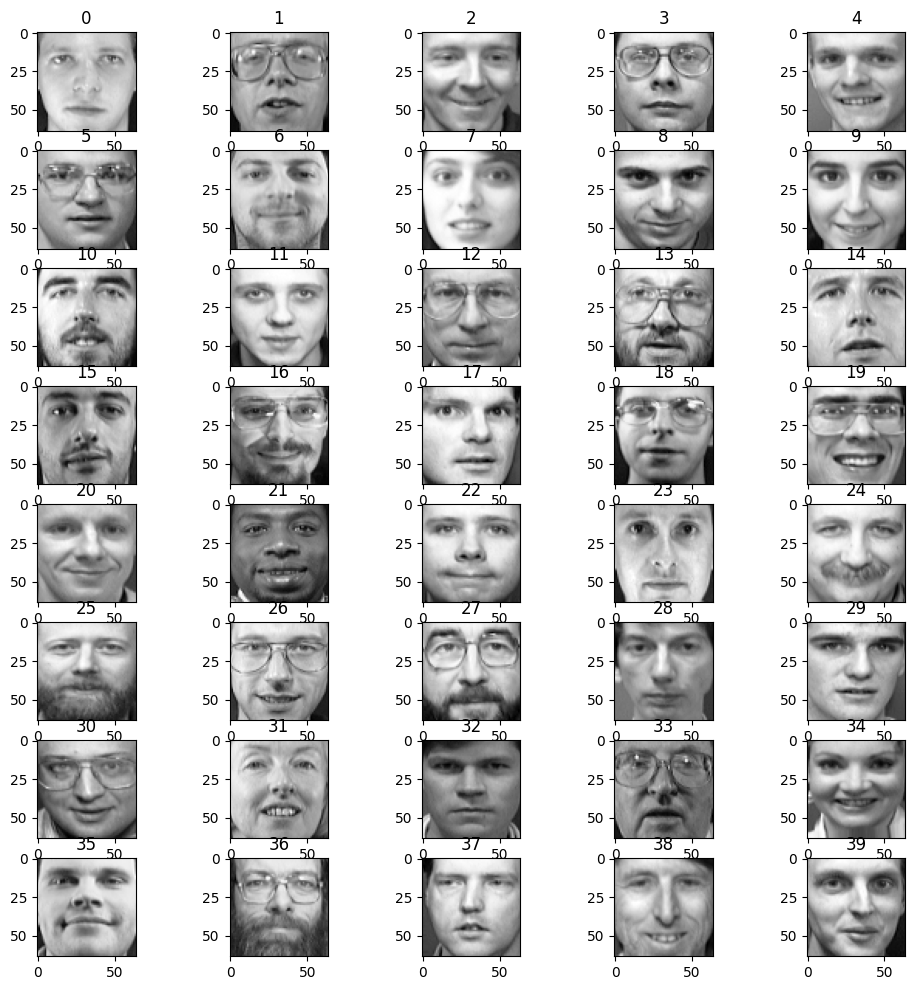

In [4]:
plot_images(faces.data, faces.target, 8, 5)

<font face="Times New Roman" size=4><div dir=ltr>
### Train-Test Split (2 points)
Split the data into train and test sets and print the dimensions of each set. (70% for train and 30% for test)

In [5]:
# n_t = int(faces.data.shape[0] * 0.7)
# X_train = faces.data[:n_t,:]
# y_train = faces.target[:n_t]
# X_test = faces.data[n_t:,:]
# y_test = faces.target[n_t:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, random_state=42, test_size=0.3, stratify=faces.target)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(280, 4096)
(280,)
(120, 4096)
(120,)


<font face="Times New Roman" size=4><div dir=ltr>
### Dimensionality Reduction (18 points)
As you might have guessed, the number of featuers, i.e. pixels, is quite large and training a classifier might take a considerbale time. However, using a wise method to reduce the dimension of our data could decrease the cost of training the model. In the following cell use PCA (Principal Component Analysis) to reduce the dimension of the dataset. Choose an appropirate number of components in your PCA and explain your reason for your choice.

PCA is an algorithm used for reducing the dimension of data. Assuming we have $d$ dimensions and $t$ training sets which we want to reduce the dimension to $k$, the steps are as follows:
    - data normalization: we compute the mean of each feature, and then we replace each feature, f, with f minus its mean (this process is referred to as mean normalization, we can also perform feature scaling by dividing it by the standard deviation)
    - calculate the covariance matrix: either by using np.cov or $X^T X$
    - compute eigen vectors($V$) and eigen values of the covariance matrix. (we can use an inbuilt function in numpy for calculating covariance or use the SVD decomposition of X to get the eigenvectors of the covariance matrix)
    - get the principal components using $P = X V$ (which is the same as $P = X V = USV^T V = US$. Here we use the first $k$ rows of $V$ so this way we have described this data set using the first k principal components. (the amount of variance captured is accessible using eigen values, so we can keep just the right amount of principal components for a desired amount of variance)


In [6]:
import numpy as np


def normalize_data(X):
    # normalization: (assuming we have training sets as rows)
    miu = np.reshape(np.average(X, axis=0), (1, X.shape[1]))
    std = np.reshape(np.std(X, axis=0), (1, X.shape[1]))
    return (X - miu) / std

def get_principle_components(X, k):
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    v = vh[:k, :].transpose()
    # principle components, eigen vector, eigen values
    return X @ v, vh , s

def pca(X, k):
    X = normalize_data(X)
    return get_principle_components(X, k)

In [7]:
P, V, S = pca(X_train, 3000)
# plot the eigen faces:
# plot_images(P, Y_train, 7, 4)

# P, V, S = pca(X_train, 3200)
# plot_images(V, Y_train, 7, 4)
#
# P, V, S = pca(X_train, 3500)
# plot_images(V, Y_train, 7, 4)
#
# P, V, S = pca(X_train, 3800)
# plot_images(V, Y_train, 7, 4)
#
# P, V, S = pca(X_train, 4000)
# plot_images(V, Y_train, 7, 4)

After running the algorithm for different values of k, as expected, we can see that the amount of details in each image is higher as k increases. This way, k = 3800 seems like a good choice, but we can not be sure unless we capture the variance and make sure that it gives us the minimum acceptable variance.

<font face="Times New Roman" size=4><div dir=ltr>
Plot the scree plot of the proportion of the variance explained(PVE) vs principal components to determine the number of principal components for further analysis.

We use scree plot to check if the PCA is working well on our data or not. We sort the eigenvectors by their eigenvalues. Then we can choose the cut-off point (the desired variance that is supposed to be explained by the principal components). For this, I proceeded with the sklearn pca implementation since it has useful functions for this assignment.

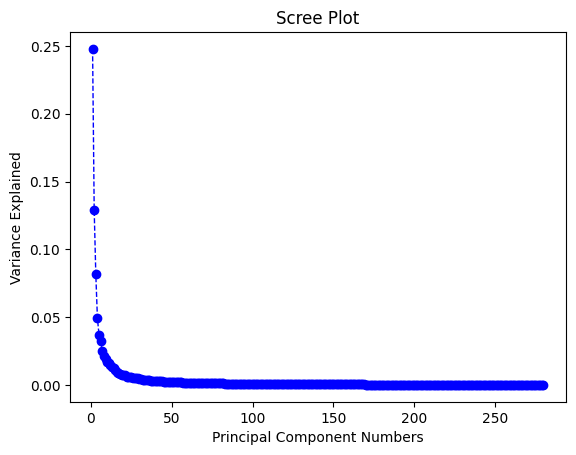

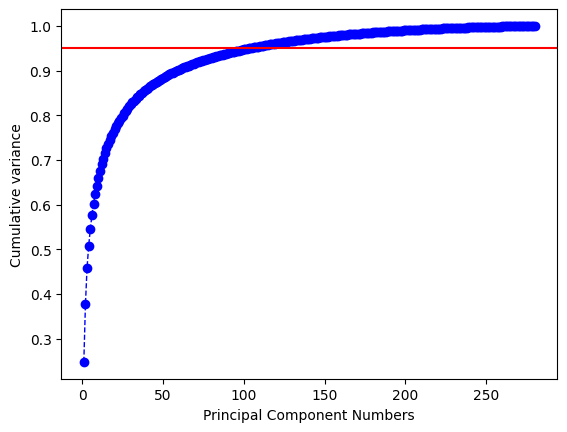

In [8]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)
plt.plot(np.arange(pca.n_components_)+1, pca.explained_variance_ratio_, marker='o', linestyle='--', color='b', linewidth = 1)
plt.title('Scree Plot')
plt.xlabel('Principal Component Numbers')
plt.ylabel('Variance Explained')
plt.show()

plt.plot(np.arange(pca.n_components_)+1, np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b', linewidth = 1)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('Principal Component Numbers')
plt.ylabel('Cumulative variance')
plt.show()


Also, if we set the n_components to something between 0 and 1 such as 0.95, this will select the number of components while preserving 95% of the variability in the data.

In [9]:
pca = PCA(n_components=0.95).fit(X_train)

<font face="Times New Roman" size=4><div dir=ltr>
### Eigenfaces: Principal Components Visualization (25 points)
Plot the mean face using your PCA model with <code>pca.mean_</code> attribute followed by a reshape to original dimensions. What is this mean vector?

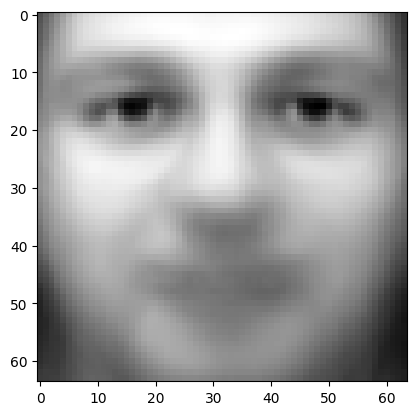

In [10]:
plt.imshow(pca.mean_.reshape(64,64), cmap='gray')

<font face="Times New Roman" size=4><div dir=ltr>
Eigenfaces is the name given to a set of eigenvectors when used in the computer vision problem of human face recognition. Plot the 30 first eigenfaces sorted by their rank from the most important to the lowest. Can you explain what these faces indicate?

We can obtain eigenfaces using the principal components.

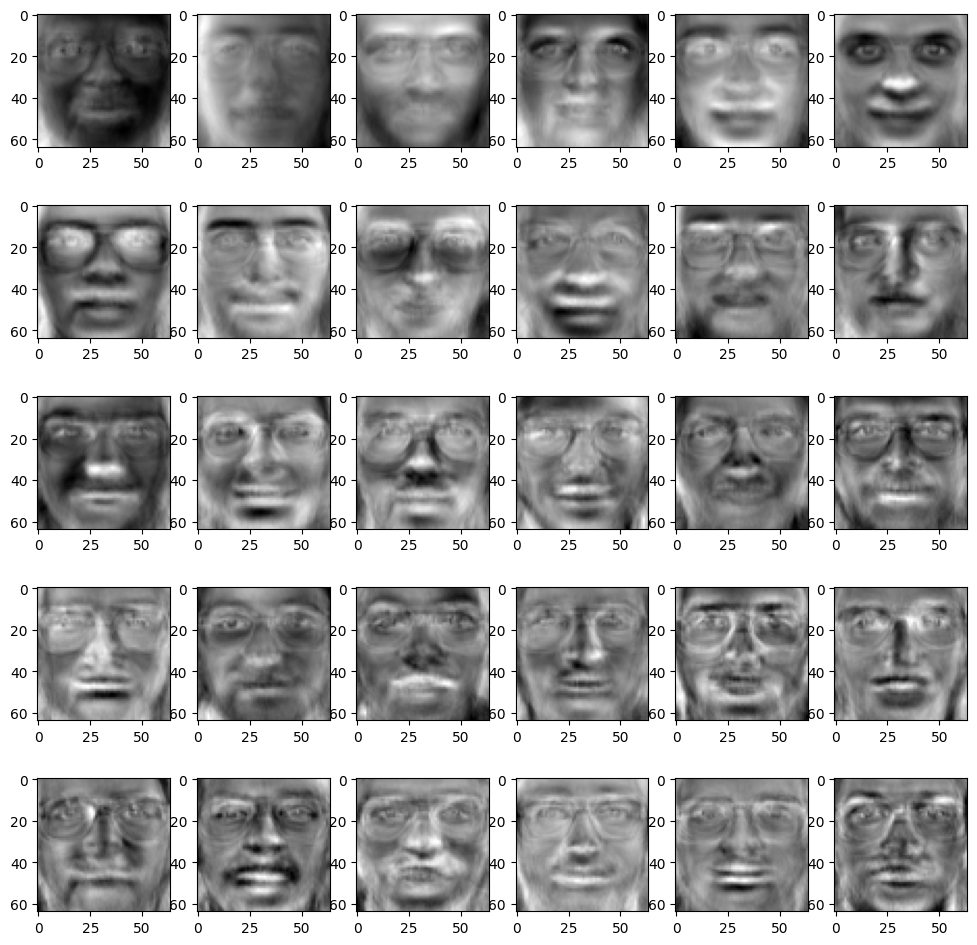

In [11]:
_, axs = plt.subplots(5, 6, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(pca.components_[:30], axs):
    ax.imshow(img.reshape(64,64), cmap='gray')
plt.show()

We can see that these eignefaces are blurry faces which contain some facial characteristics to build pictures. Principal components are ordered by their level of importance (variace of the eigenvalue) and hence the top-lef eigenface shows the most dominant features in the images (which is mostly the overall shape and the lightening) and then we can see more facial details as we go through them in order.

<font face="Times New Roman" size=4><div dir=ltr>
Transform your train and test sets to the new feature space using your PCA module. 

In [12]:
X_train_new = pca.transform(X_train)
X_test_new = pca.transform(X_test)

<font face="Times New Roman" size=4><div dir=ltr>
### Training your SVM Classifier (50 points)
Train an SVM classifier on the transformed dataset in the new feature space. You should use Grid Search Cross Validation or other validation techniques to obtain the best hyperparameters for your classifier.

GridSearchCV is used for hyperparameter tuning and it runs through all possible values for different parameters that is fed into the parameter grid and produces the best combination of parameters that minimize the cost function of a particular estimator.
In the case of SVM, our estimator is svm model and the param_grid is a dictionary containing all the parameters to try. For example, hyperparameters in svm include the kernel, C(regularization parameter), gamma(which defines how far the influence of a single training example reaches) and degree (of the polynomial). It also has a scoring parameter which is the evaluation metric to use when ranking results and a cv parameter which defines the cross-validation splitting strategy (it's k-fold as default) . We can use the default values for scoring and cv.

In [13]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
params = {'kernel':('linear','rbf','poly'), 'C':[1,2,3,4,5,6,7,8,9,10,11,12,15,20], 'degree':[1,2,4,6,8,10], 'gamma':[1,0.1,0.01,0.001,0.009,0.003,0.0001]}
grid = GridSearchCV(svm.SVC(), param_grid=params)
grid.fit(X_train_new, y_train)
grid.best_params_

{'C': 1, 'degree': 1, 'gamma': 1, 'kernel': 'linear'}

In [14]:
clf = svm.SVC(kernel='linear', C=1, gamma=1, random_state=42)
clf.fit(X_train_new, y_train)

SVC(C=1, gamma=1, kernel='linear', random_state=42)

<font face="Times New Roman" size=4><div dir=ltr>
After training your model, we can check its prediction on test samples. Run the following cell to check your model predictions with the target values on test samples. Predictions with red label indicate false classification of your model.

(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)
(120, 104)


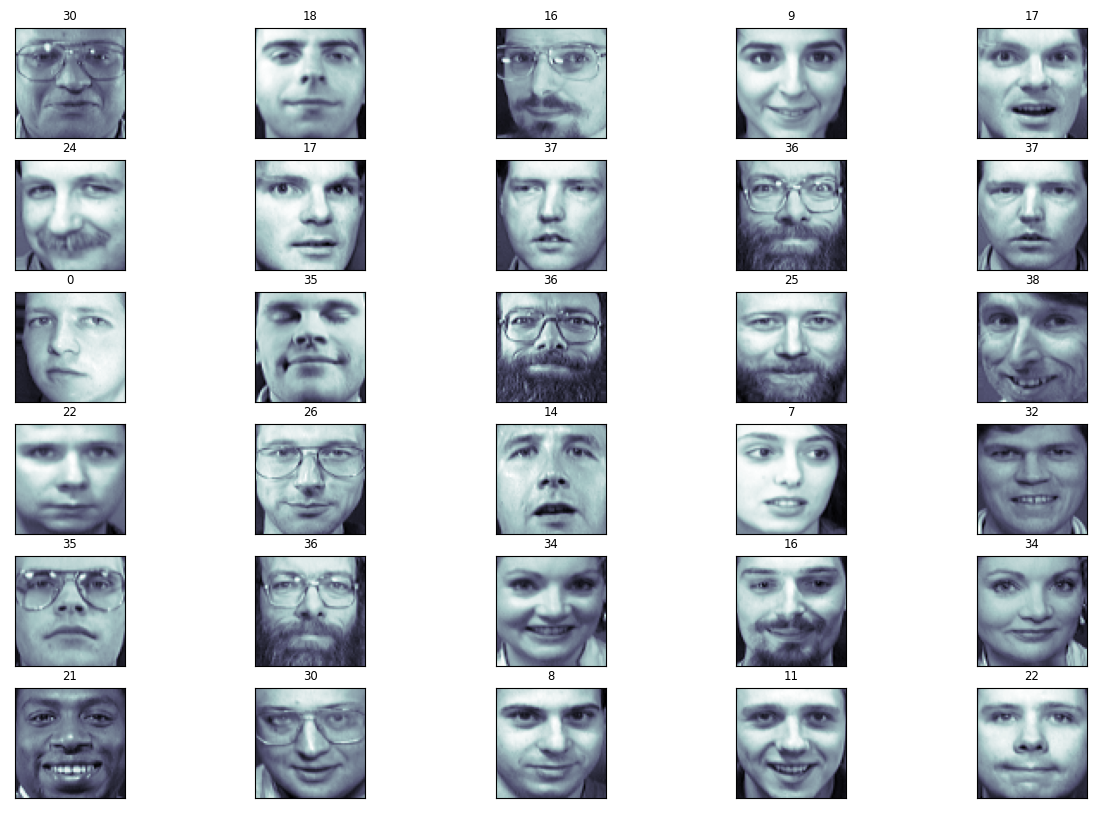

In [15]:
fig = plt.figure(figsize=(15, 10))
for i in range(30):
    ax = fig.add_subplot(6, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
    print(X_test_new.shape)
    y_pred = clf.predict(X_test_new[i, np.newaxis])[0] #X_test_new is the transformed X_test after PCA.
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)

<font face="Times New Roman" size=4><div dir=ltr>
## Performance Measures
Let's evaluate your classifier to find out how good your model is.
    
    
### Precision Recall Tradeoff (20 points)
Plot the precision and recall versus the decision threshold figure and precision vs recall figure.

I used the code in sklearn documentation for precision vs recall figure.

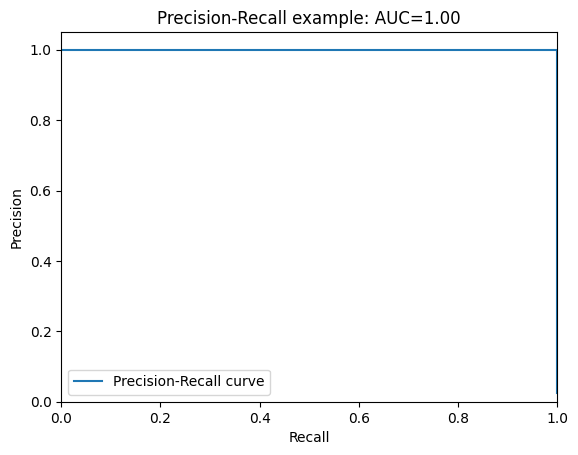

Precision-recall curve of class 0 (area = 1.00)
Precision-recall curve of class 1 (area = 1.00)
Precision-recall curve of class 2 (area = 1.00)
Precision-recall curve of class 3 (area = 1.00)
Precision-recall curve of class 4 (area = 0.79)
Precision-recall curve of class 5 (area = 1.00)
Precision-recall curve of class 6 (area = 1.00)
Precision-recall curve of class 7 (area = 1.00)
Precision-recall curve of class 8 (area = 1.00)
Precision-recall curve of class 9 (area = 1.00)
Precision-recall curve of class 10 (area = 1.00)
Precision-recall curve of class 11 (area = 1.00)
Precision-recall curve of class 12 (area = 0.81)
Precision-recall curve of class 13 (area = 1.00)
Precision-recall curve of class 14 (area = 1.00)
Precision-recall curve of class 15 (area = 1.00)
Precision-recall curve of class 16 (area = 1.00)
Precision-recall curve of class 17 (area = 1.00)
Precision-recall curve of class 18 (area = 1.00)
Precision-recall curve of class 19 (area = 1.00)
Precision-recall curve of clas

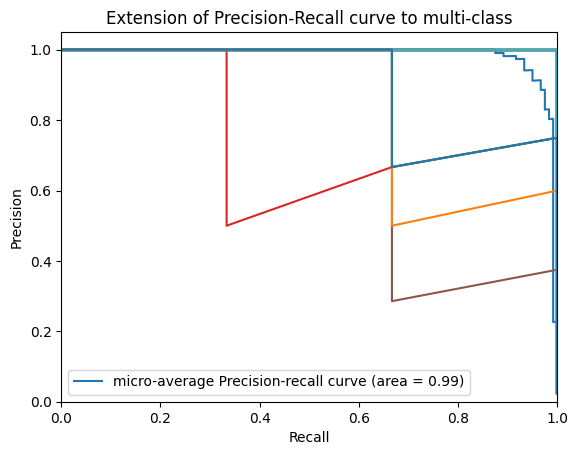

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

y_train_b, y_test_b = label_binarize(y_train, classes=[i for i in range(40)]), label_binarize(y_test, classes=[i for i in range(40)])
classifier = OneVsRestClassifier(clf)
y_score = classifier.fit(X_train_new,y_train_b).decision_function(X_test_new)
precision = dict()
recall = dict()
threshold = dict()
average_precision = dict()
for i in range(40):
    precision[i], recall[i], threshold[i] = precision_recall_curve(y_test_b[:,i], y_score[:,i])
    average_precision[i] = average_precision_score(y_test_b[:,i], y_score[:,i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], threshold["micro"] = precision_recall_curve(y_test_b.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_b, y_score,
                                                     average="micro")

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["micro"], precision["micro"],
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i in range(40):
    plt.plot(recall[i], precision[i])
    print('Precision-recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="best")
plt.show()

# # Plot Precision-Threshold curve for each class
# plt.clf()
# print(threshold.__len__(), precision.__len__())
# # plt.plot(threshold["micro"], precision["micro"],
# #          label='micro-average Precision-threshold curve (area = {0:0.2f})'
# #                ''.format(average_precision["micro"]))
# for i in range(40):
#     plt.plot(threshold[i], precision[i])
# plt.xlabel('Decision Threshold')
# plt.ylabel('Precision')
# plt.title('Extension of Precision-Decision curve to multi-class')
# plt.legend(loc="best")
# plt.show()


<font face="Times New Roman" size=4><div dir=ltr>
Then find the decision threshold, where the recall is equal to the precision. Write down it in the below cell:
    <br>
note: it should be apparent in the above figures.

From the curve above, 0.94 seems like is the threshold
decision_threshold = 0.9

recall at the above threshold = 0.94

<font face="Times New Roman" size=4><div dir=ltr>
### ROC/AUC (10 points)
Train a RandomForestClassifier with 30 estimators then plot a ROC curve, and calculate AUC for both randomForsetClassifier and your SVM classifier that you trained earlier, which one is the best by considering AUC indicator?


In [17]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=30)
rfc.fit(X_train_new,y_train)
y_pred_rfc = rfc.predict(X_test_new)

ROC curve of class 0 (area = 1.00)
ROC curve of class 1 (area = 1.00)
ROC curve of class 2 (area = 1.00)
ROC curve of class 3 (area = 1.00)
ROC curve of class 4 (area = 0.99)
ROC curve of class 5 (area = 1.00)
ROC curve of class 6 (area = 1.00)
ROC curve of class 7 (area = 1.00)
ROC curve of class 8 (area = 1.00)
ROC curve of class 9 (area = 1.00)
ROC curve of class 10 (area = 1.00)
ROC curve of class 11 (area = 1.00)
ROC curve of class 12 (area = 0.99)
ROC curve of class 13 (area = 1.00)
ROC curve of class 14 (area = 1.00)
ROC curve of class 15 (area = 1.00)
ROC curve of class 16 (area = 1.00)
ROC curve of class 17 (area = 1.00)
ROC curve of class 18 (area = 1.00)
ROC curve of class 19 (area = 1.00)
ROC curve of class 20 (area = 0.99)
ROC curve of class 21 (area = 1.00)
ROC curve of class 22 (area = 1.00)
ROC curve of class 23 (area = 1.00)
ROC curve of class 24 (area = 1.00)
ROC curve of class 25 (area = 1.00)
ROC curve of class 26 (area = 1.00)
ROC curve of class 27 (area = 1.00)
RO

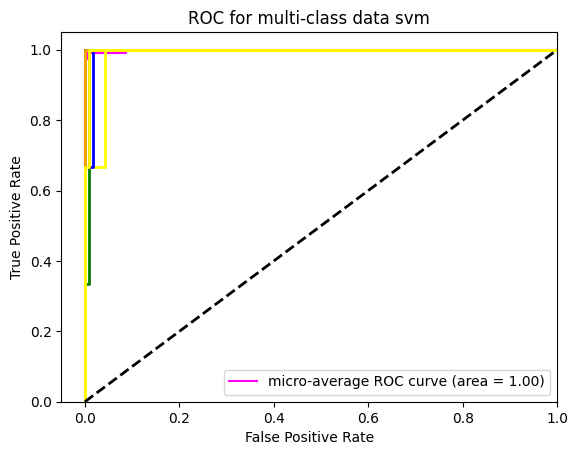

ROC AUC score for  svm is: 0.9992165242165243
ROC curve of class 0 (area = 0.66)
ROC curve of class 1 (area = 0.83)
ROC curve of class 2 (area = 0.67)
ROC curve of class 3 (area = 0.67)
ROC curve of class 4 (area = 0.83)
ROC curve of class 5 (area = 0.99)
ROC curve of class 6 (area = 0.67)
ROC curve of class 7 (area = 1.00)
ROC curve of class 8 (area = 1.00)
ROC curve of class 9 (area = 0.67)
ROC curve of class 10 (area = 1.00)
ROC curve of class 11 (area = 1.00)
ROC curve of class 12 (area = 0.67)
ROC curve of class 13 (area = 1.00)
ROC curve of class 14 (area = 1.00)
ROC curve of class 15 (area = 0.99)
ROC curve of class 16 (area = 0.83)
ROC curve of class 17 (area = 1.00)
ROC curve of class 18 (area = 1.00)
ROC curve of class 19 (area = 1.00)
ROC curve of class 20 (area = 0.99)
ROC curve of class 21 (area = 1.00)
ROC curve of class 22 (area = 1.00)
ROC curve of class 23 (area = 1.00)
ROC curve of class 24 (area = 1.00)
ROC curve of class 25 (area = 0.83)
ROC curve of class 26 (area 

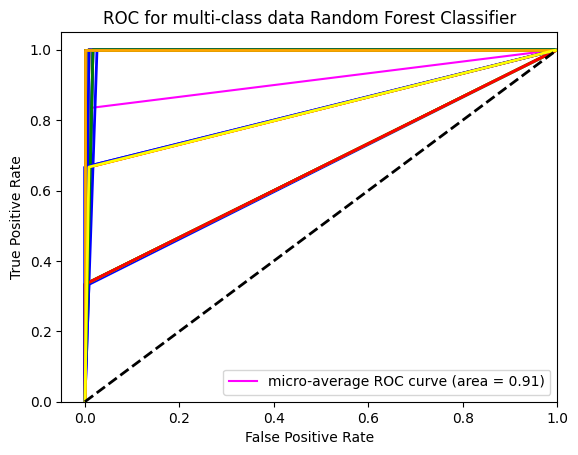

ROC AUC score for  Random Forest Classifier is: 0.9145299145299145


In [33]:
from itertools import cycle
from sklearn.metrics import roc_curve, roc_auc_score ,auc
import pandas as pd
#TODO: plot roc_curve and print roc_auc_score for svm and random forest classifiers
def plot_multiclass_roc(y_score, name):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(40):
        fpr[i], tpr[i], _ = roc_curve(y_test_b[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_b.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # plt.clf()
    plt.plot(fpr["micro"], tpr["micro"], label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]), color="magenta")
    colors = cycle(['blue', 'red', 'green', 'orange','yellow'])
    for i, color in zip(range(40), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2)
        print('ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for multi-class data'+name)
    plt.legend(loc="best")
    plt.show()
    print("ROC AUC score for "+name+" is: "+ str(roc_auc_score(y_test_b, y_score, average='macro', multi_class='ovo')))

plot_multiclass_roc(y_score,' svm')
plot_multiclass_roc(label_binarize(y_pred_rfc, classes=[i for i in range(40)]),' Random Forest Classifier')

We can see that auc score for svm is higher.

<font face="Times New Roman" size=4><div dir=ltr>
### Classification Report (5 points)
Use the <code>classification_report</code> to describe the performance of your SVM model with different metrics. Explain your results and compare the predictions of model on different classes in few sentences.

In [22]:
from sklearn import metrics
y_prediction = clf.predict(X_test_new)
print(metrics.classification_report(y_test,y_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      0.67      0.80         3
           5       0.75      1.00      0.86         3
           6       1.00      1.00      1.00         3
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         3
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       0.75      1.00      0.86         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
          17       1.00    

<font face="Times New Roman" size=4><div dir=ltr>
### Confusion Matrix (15 points)
Plot the confusion matrix of the classifier's predictions.
Let’s focus on the errors of the plot. Divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute number of errors, then plot the result.

In [26]:
# TODO: calculate conf_mx then print it
confusion_mat = metrics.confusion_matrix(y_test,y_prediction,normalize='all')
print(confusion_mat)

[[0.025 0.    0.    ... 0.    0.    0.   ]
 [0.    0.025 0.    ... 0.    0.    0.   ]
 [0.    0.    0.025 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.025 0.    0.   ]
 [0.    0.    0.    ... 0.    0.025 0.   ]
 [0.    0.    0.    ... 0.    0.    0.025]]


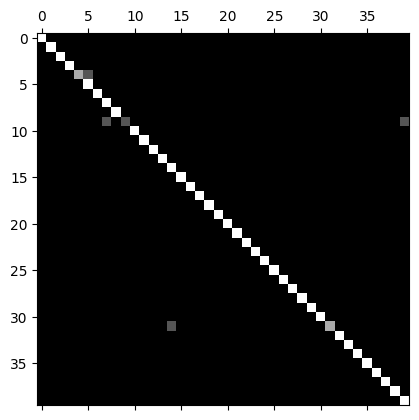

In [27]:
# TODO: after calculating confusion matrix, visualize it using below code
plt.matshow(confusion_mat, cmap=plt.cm.gray)
plt.show()